# Criticality
This notebook contains experiments in determining how far away a network is from criticality. Also, what happens if you homeostatically regulate firing rates?

In [1]:
%matplotlib nbagg
import numpy as np
from scipy import optimize, stats, signal

from braingeneers import drylab
from braingeneers.analysis import temporal_binning, find_avalanches, vuong

import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
from functools import partial

In [2]:
# This is specific to my MPL configuration...
plt.style.use('arxiv')

In [3]:
def raster_plot(times, idces, N=None, tmin=None, tmax=None):
    
    N = N or np.max(idces)+1
    tmin = tmin or 0
    tmax = tmax or np.max(times)
    
    if tmin > np.min(times) or tmax < np.max(times):
        i = (times > tmin) & (times < tmax)
        times = times[i]
        idces = idces[i]
        
    ax = plt.figure().gca()
    ax.plot(times, idces + 1, '.', markersize=0.5)
    ax.set_xlim([tmin, tmax])
    ax.set_ylim([1, N])
    return ax

In [47]:
def truncate(dist):
    """
    Apply to a Scipy random variable class to truncate it.
    This was nonsensically broken because Scipy 1.2.1 had
    a bad implementation of truncated norm and expon.
    """
    
    class truncated_gen(stats.rv_continuous):
        "A truncated continuous random variable."
           
        _support_mask = stats.rv_continuous._open_support_mask
        
        def _argcheck(self, a, b, *args, **kwargs):
            return (a < b) and dist._argcheck(*args, **kwargs)

        def _get_support(self, a, b, *args, **kwargs):
            try:
                dista, distb = dist.a, dist.b
            except AttributeError:
                dista, distb = dist._get_support(*args, **kwargs)
            return max(a, dista), min(b, distb)

        def _get_norms(self, a, b, *args, **kwargs):
            _na, _nb = dist.cdf([a,b], *args, **kwargs)
            _sa, _sb = dist.sf([a,b], *args, **kwargs)
            # Accounts for numerical issues in subtraction.
            _delta = np.where(_na > 0.5, _sa - _sb, _nb - _na)
            with np.errstate(divide='ignore'):
                return _na, _nb, _sa, _sb, _delta, np.log(_delta)

        def _pdf(self, x, a, b, *args, **kwargs):
            _delta = self._get_norms(a, b, *args, **kwargs)[4]
            return dist._pdf(x, *args, **kwargs) / _delta

        def _cdf(self, x, a, b, *args, **kwargs):
            ans = self._get_norms(a, b, *args, **kwargs)
            _na, _delta = ans[0], ans[4]
            return (dist._cdf(x, *args, **kwargs) - _na) / _delta

        def _ppf(self, q, a, b, *args, **kwargs):
            _na, _nb, _sa, _sb = self._get_norms(a, b, *args, **kwargs)[:4]
            ppf = np.where(_na > 0.5,
                           dist._isf(q*_sb + _sa*(1.0-q), *args, **kwargs),
                           dist._ppf(q*_nb + _na*(1.0-q), *args, **kwargs))
            return ppf
        
    shapes = 'm, M'
    if dist.shapes is not None:
        shapes = shapes + ', ' + dist.shapes
    truncated = truncated_gen(name='truncated ' + dist.name, shapes=shapes)
    return truncated


# Generate a Small-World Random Graph

In [15]:
def small_world(XY, plocal, beta):
    """
    This model is inspired by the Watts-Strogatz model as 
    described by Buzsaki, but describing the relationships
    between objects with physical positions rather than on
    an abstract cycle. 
    """
    # Number of nodes.
    N = XY.shape[1]
    
    # Symmetric array of distances between nodes i and j.
    dij = np.sqrt(np.sum((XY[:,:,None] - XY[:,None,:])**2, axis=0))
    
    # Connect every arrow with distance less than 1.
    edges = (dij < 1) & (np.random.rand(N,N) < plocal)
    
    # Relocate edges with probability beta, keeping 
    # the same origin but changing the target.
    to_change = edges & (np.random.rand(N,N) < beta)
    edges ^= to_change
    new_edges = to_change.sum(0)
    for j,n in enumerate(new_edges):
        targets = np.random.choice(N, size=n, replace=False)
        edges[targets,j] = True
    
    np.fill_diagonal(edges, False)
    return edges

# Generate a Scale-Free Random Graph

In [16]:
def ba_model(N, m, m0=None, directed=True, randomize_m=False):
    """
    Use the Barabási-Albert model of preferential attachment 
    to generate the adjacency matrix of a graph with N nodes
    whose degree is distributed according to a power law. The
    parameter m is approximately the average node degree.
    """
    
    # An adjacency matrix. If you right-multiply the vector 
    # which is zero except the ith element, the result is the
    # vector with ones at the indices corresponding to nodes
    # which have incident edges from node i. In other words,
    # the ith column contains the edges leaving node i.
    edges = np.zeros((N,N), dtype=np.bool)
    
    # The initial graph should be K_{m0}. Also note that when
    # m0=1, the first step is deterministic and equivalent to 
    # the case where m0=2, with m still equal to 1, so we do
    # that here to avoid special-casing the logic in the loop.
    if m0 is None: m0 = m
    if m0 == 1: m0 = 2
    edges[:m0,:m0] = 1 - np.eye(m0)
        
    # Now add the rest of the nodes, each of which has m 
    # independent in and out edges.
    in_degree = edges.sum(axis=1)
    out_degree = edges.sum(axis=0)
    
    for n in range(m0,N):
        
        m_in = m if not randomize_m else np.random.geometric(1/m)
        from_n = np.random.choice(n, m_in, replace=False, 
                                  p=in_degree[:n] / in_degree.sum())
        
        if not directed:
            to_n = from_n
        else:
            m_out = m if not randomize_m else np.random.geometric(1/m)
            tox_n = np.random.choice(n, m_out, replace=False, 
                                    p=out_degree[:n] / out_degree.sum())
            
        in_degree[from_n] += 1
        in_degree[n] += m_in
        
        out_degree[to_n] += 1
        out_degree[n] += m_out
        
        edges[from_n,n] = 1
        edges[n,to_n] = 1
        
        
    # Finally, permute the nodes of the graph so the
    # first m0 elements aren't special in any way.
    permutation = np.eye(N)[np.random.permutation(N),:]
    return (permutation.T @ edges @ permutation) != 0

## Simulate Spikes In Here

In [17]:
# Number of neurons, followed by the number which are excitatory.
N = 1000
Ne = 800

# Use a homogeneous population so things are clearer, differentiated
# only by type. 
a, b, c, d, C, k, Vr, Vt = np.array(N * [drylab.NEURON_TYPES['rs']]).T

# tau : ms time constant of synaptic current
tau = np.hstack((Ne*[5], (N-Ne)*[20]))

Vp = 30

vstar = 1/2 * (Vt + Vr + b/k)
ustar = b * (vstar - Vr)
Istar = k/4 * (Vt - Vr + b/k)**2

In [18]:
# Sij : fC total postsynaptic charge injected into
#       neuron i when neuron j fires. Song (2005)
#       provide an empirical distribution for EPSPs.
mu, sigma = -0.702, 0.9355  
S = np.random.lognormal(mean=mu, sigma=sigma, size=(N,N))
# Then convert the EPSPs to injected synaptic charge.
S *= np.median(C / tau)

# XY : um planar positions of the cells,
# dij : um distances between cells
XY = np.random.rand(2,N) * 75

# Generate random small-world connectivity using the
# XY defined right here, but with long-range inhibition
# prohibited.
beta = np.zeros((N,N))
beta[:,:Ne] = 0.1
S *= 1*small_world(XY / 15, plocal=0.7, beta=beta)

# Make inhibitory cells stronger than excitatory cells.
S[:,Ne:] *= -5

excitatory = np.arange(N) < Ne

In [19]:
# What is the probability that any given synapse is bidirectional?
edges = S != 0
bidir = edges & edges.T
unidir = edges & ~bidir

print(f'We have {100*bidir.sum()/N**2:0.1f}% bidirectional',
      f'and {100*unidir.sum()/N**2:0.1f}% uni-directional probability.')

We have 4.4% bidirectional and 2.9% uni-directional probability.


In [20]:
# Sample rate (kHz) and timestep (ms)
fs = dt = 1
tmax = 1 * 60 * 1000

# Create the actual Organoid.
org = drylab.Organoid(XY=XY, S=S, tau=tau, Vp=Vp, Vr=Vr, Vt=Vt,
                      a=a, b=b, c=c, d=d, k=k, C=C,
                      do_stdp=False, stdp_smin=-750, stdp_smax=500)
org.V = vstar
org.U = ustar

firing = np.random.randint(N)
org.fired[firing] = True

# Initialize and run the loop.
spike_times, spike_idces = [0], [firing]
for t in tqdm(range(tmax)):

    # Stimulate a random 0.1% of the cells.
    Iin = Istar + 15*(np.random.rand(N) <= 0.1/100)*np.random.randn(N)
    org.step(dt, Iin)

    for i in np.arange(N)[org.fired]:
        spike_times.append(t)
        spike_idces.append(i)

In [21]:
spike_times = np.array(spike_times)
spike_idces = np.array(spike_idces, dtype=np.int32)
print(f'There were {len(spike_times) / (tmax/1000)} spikes per second.')

There were 369.35 spikes per second.


<IPython.core.display.Javascript object>


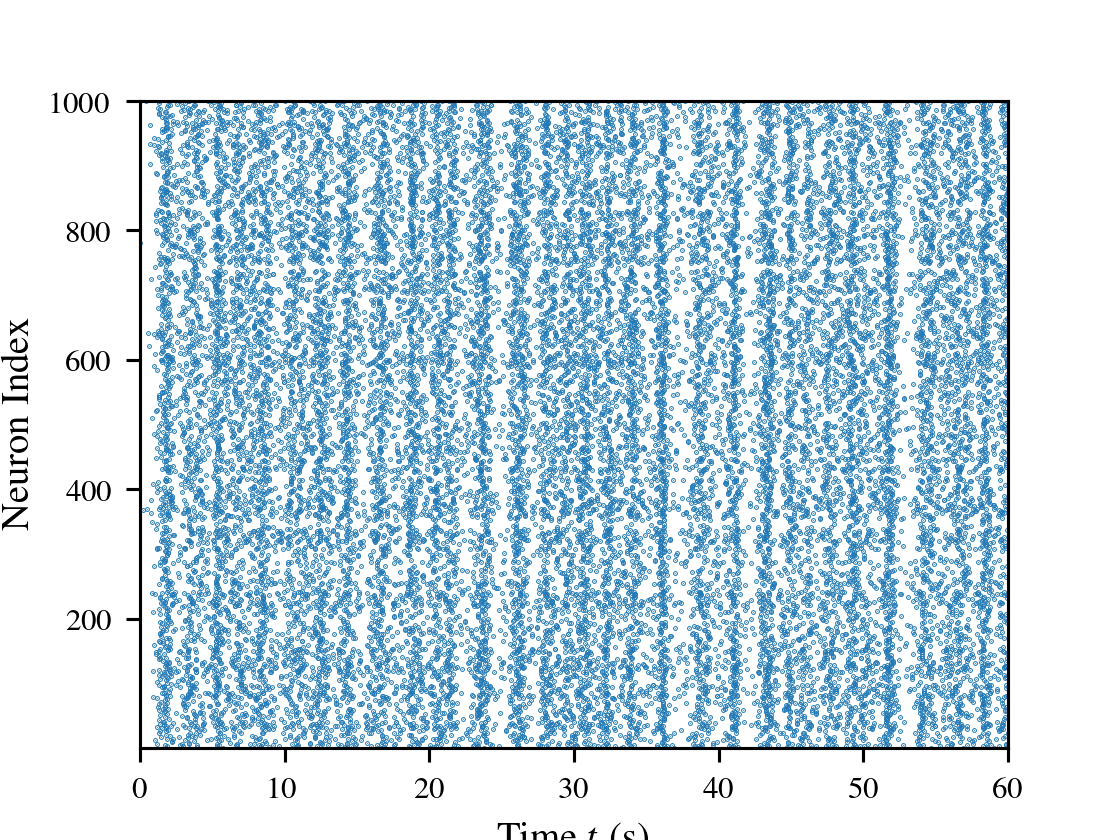

Text(0, 0.5, 'Neuron Index')

In [22]:
ax = raster_plot(spike_times/1e3, spike_idces, N=N)
ax.set_xlabel('Time $t$ (s)')
ax.set_ylabel('Neuron Index')

## Count the Counts, Find the Threshold

In [23]:
def temporal_binning(spike_times, bin_size, tmax=None):
    """
    Given a sorted list of spike times (with no channel or neuron 
    number information), quantizes time into intervals of bin_size 
    and counts the number of events in each bin.
    """
    # Create enough bins to hold all the spikes.
    if tmax is None:
        tmax = spike_times[-1]
    n_bins = (tmax + bin_size - 1) // bin_size
    counts = np.zeros(n_bins, np.int)
        
    bins, bin_counts = np.unique(spike_times // bin_size, 
                                 return_counts=True)
    counts[bins] = bin_counts
    return counts


In [24]:
%%time
bin_size = 20
counts = temporal_binning(spike_times, bin_size=bin_size)

CPU times: user 1.62 ms, sys: 1.12 ms, total: 2.74 ms
Wall time: 1.23 ms


In [25]:
# counts = temporal_binning(spike_times)
thresh = stats.mstats.mquantiles(counts, [0.3])[0]
print(f'Thresholding at {thresh}')

Thresholding at 4.0


<IPython.core.display.Javascript object>


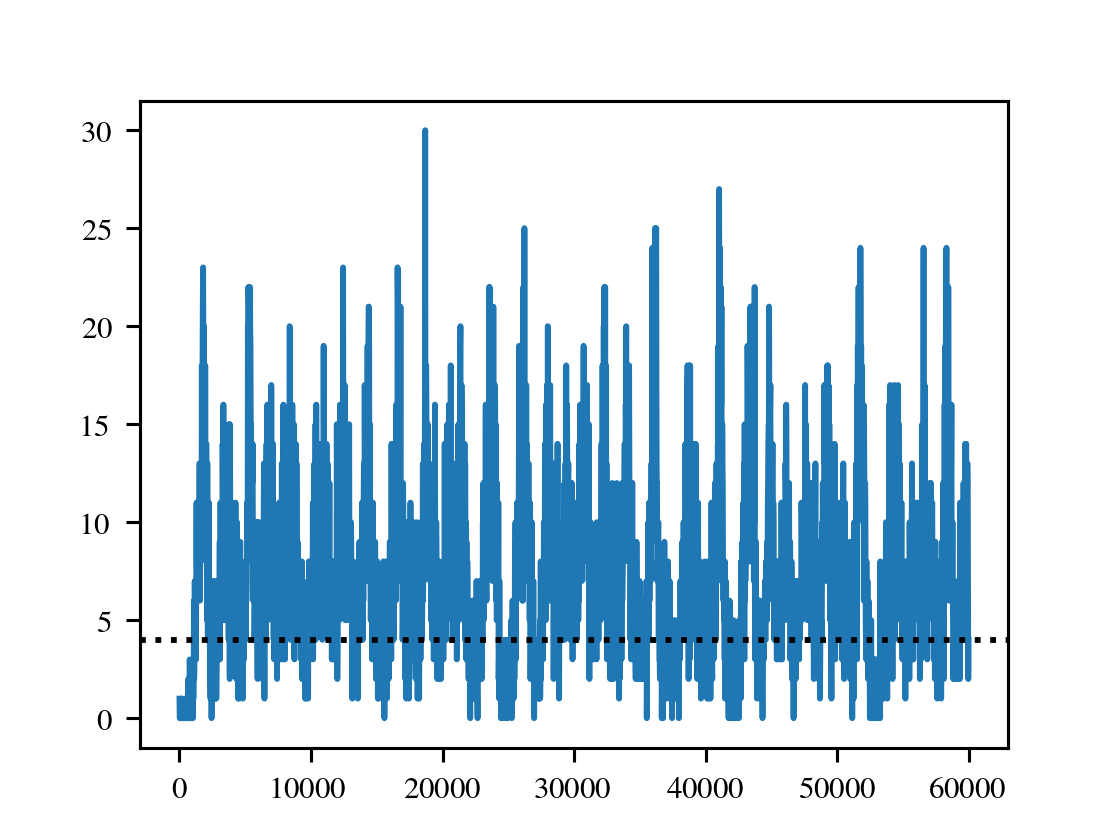

In [26]:
ax = plt.figure().gca()
ax.plot(np.arange(len(counts))*bin_size, counts)
ax.axhline(thresh, linestyle=':', color='k')

In [27]:
sizes, durations = np.array(find_avalanches(counts, thresh)).T
durations = durations * bin_size/1000
print(f'There were {len(sizes)} avalanches!')
print(f'  Size: {sizes.min()} to {sizes.max()} spikes.')
print(f'  Duration: {int(1000*durations.min())}ms to {int(1000*durations.max())}ms.')

There were 315 avalanches!
  Size: 4 to 681 spikes.
  Duration: 20ms to 1400ms.


## Scale-Free Avalanche Shapes?
Scale-free dynamics should have the property that avalanches of different sizes look like scaled copies of each other. The simulated example does not exhibit this property at all: there is no relationship between avalanche shapes, even if we restrict ourselves to avalanches above a certain size.

<IPython.core.display.Javascript object>


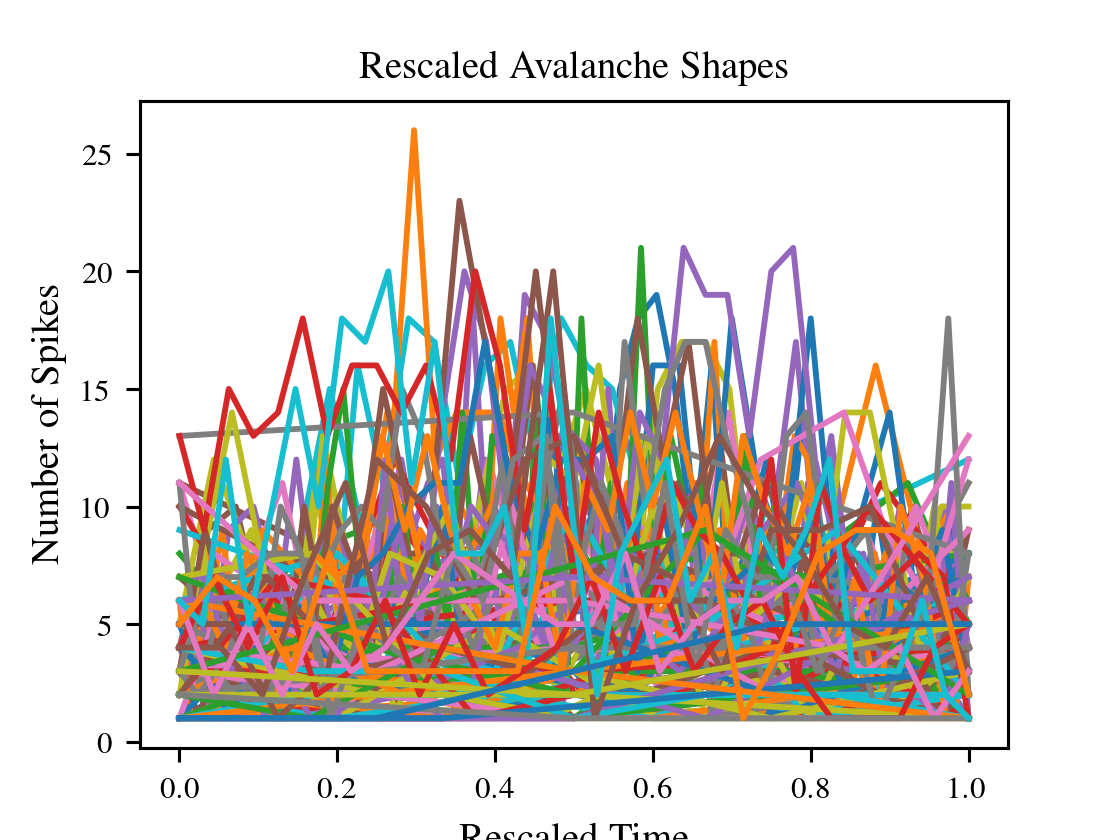

In [28]:
ax = plt.figure().gca()      
ax.set_title('Rescaled Avalanche Shapes')
ax.set_xlabel('Rescaled Time')
ax.set_ylabel('Number of Spikes')

av = []
for count in counts:
    if count > thresh:
        av.append(count - thresh)
    else:
        if len(av) > 2:
            av = np.array(av)
            ax.plot(np.linspace(0,1, len(av)), av)
        av = []
  

## Fitting Distributions
Try fitting both a power-law and a lognormal distribution to the observed distribution of avalanche sizes and durations (via the maximum likelihood method), then compare the predictions of those two fits using the Vuong test. 

The Vuong statistic is a measure (based on a likelihood ratio) of how sure we can be based on a certain sample that data fits model A better than model B. If the two models fit equally well, the statistic follows the standard normal distribution. Here, we estimate the Vuong statistic by doing little Vuong tests on many independent samples of the observed avalanche distribution, as well as on samples of the two fitted distributions. It is obvious, at least for now, that the lognormal model fits the data very well and the power-law model does not. 

In [48]:
powerlaw = truncate(stats.powerlaw)
lognorm = truncate(stats.lognorm)

In [126]:
np.ptp(sizes)

677

In [129]:
scale = np.ptp(sizes)
size_pl = powerlaw(*powerlaw.fit(sizes, f0=thresh/scale, f1=1, floc=0, fscale=scale))
size_ln = lognorm(*lognorm.fit(sizes, f0=thresh, f1=np.inf, floc=0, fscale=1))

scale = np.ptp(durations)
duration_pl = powerlaw(*powerlaw.fit(durations, f0=bin_size/1000/scale, f1=1, floc=0, fscale=scale))
duration_ln = lognorm(*lognorm.fit(durations, f0=bin_size/1000, f1=np.inf, floc=0, fscale=1))

In [130]:
def vuong_sample(rvs, distA, distB, n=1000, k=30):
    """
    Draw n samples of the Vuong statistic given a distribution
    sampling function `rvs` and two scipy.stats distribution
    objects `distA` and `distB` to compare to.
    """
    return np.array([vuong(rvs(k), distA, distB)[0]
                     for _ in range(n)])

In [131]:
def empirical_pdf(ax, x, label=None, **kwargs):
    _, _, patches = ax.hist(x, label=label, density=True, 
                            histtype='step', **kwargs)
    
    # If we plotted multiple datasets in the same histogram 
    # call, patches is a list of lists, otherwise just a list.
    for poly_list in patches:
        try:
            poly_list[0]
        except TypeError:
            poly_list = [poly_list]
            
        for poly in poly_list:
            r, g, b, _ = poly.get_edgecolor()
            poly.set_facecolor((r,g,b,0.1))
            poly.set_fill(True)
        

In [132]:
vuong_real = vuong_sample(partial(np.random.choice, sizes), size_ln, size_pl)
vuong_ln = vuong_sample(size_ln.rvs, size_ln, size_pl)
vuong_pl = vuong_sample(size_pl.rvs, size_ln, size_pl)

<IPython.core.display.Javascript object>


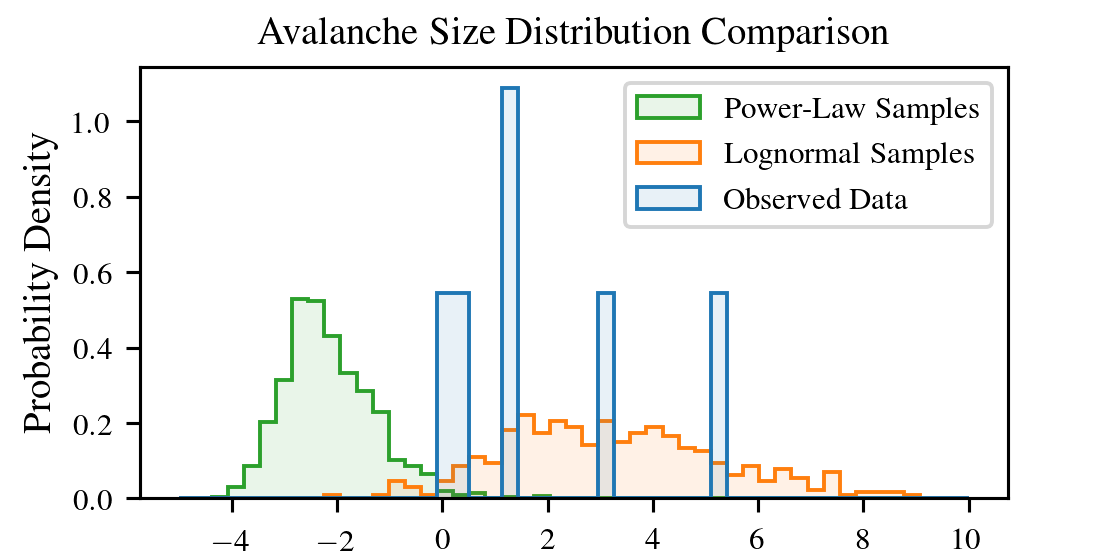

In [133]:
ax = plt.figure(figsize=(4,2)).gca()
ax.set_title('Avalanche Size Distribution Comparison')
ax.set_xlabel('Vuong Statistic')
ax.set_ylabel('Probability Density')
bins = np.linspace(-5, 10)
empirical_pdf(ax, (vuong_real, vuong_ln, vuong_pl), 
              bins=bins, label=('Observed Data', 
                                'Lognormal Samples', 
                                'Power-Law Samples'))
ax.legend()

## Direct Distribution Comparison
Here, we plot the difference between the observed distribution histogram, and the two maximum-likelihood estimated probability distributions. The results are pretty impossible to argue in this case as well. An exponential distribution also fits pretty well, but lognormal is a little bit better.

<IPython.core.display.Javascript object>


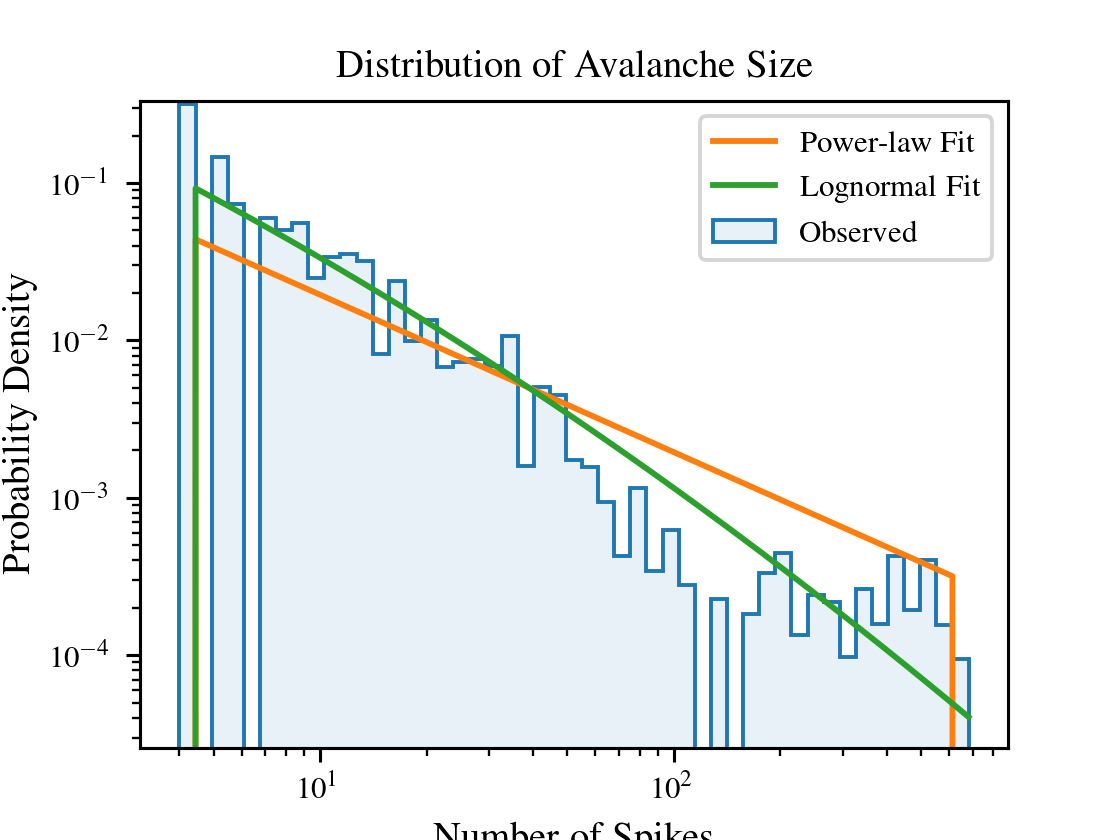

In [134]:
ax = plt.figure().gca()
ax.set_title('Distribution of Avalanche Size')
ax.set_ylabel('Probability Density')
ax.set_xlabel('Number of Spikes')

srange = np.geomspace(sizes.min(), sizes.max())
empirical_pdf(ax, sizes, bins=srange, label='Observed')
ylim = ax.get_ylim()[1]

ax.loglog(srange, size_pl.pdf(srange), label='Power-law Fit')
ax.plot(srange, size_ln.pdf(srange), label='Lognormal Fit')

ax.set_ylim(ax.get_ylim()[0], ylim)
ax.legend()

In [135]:
duration_pl.support()

(0.02, 1.38)

<IPython.core.display.Javascript object>


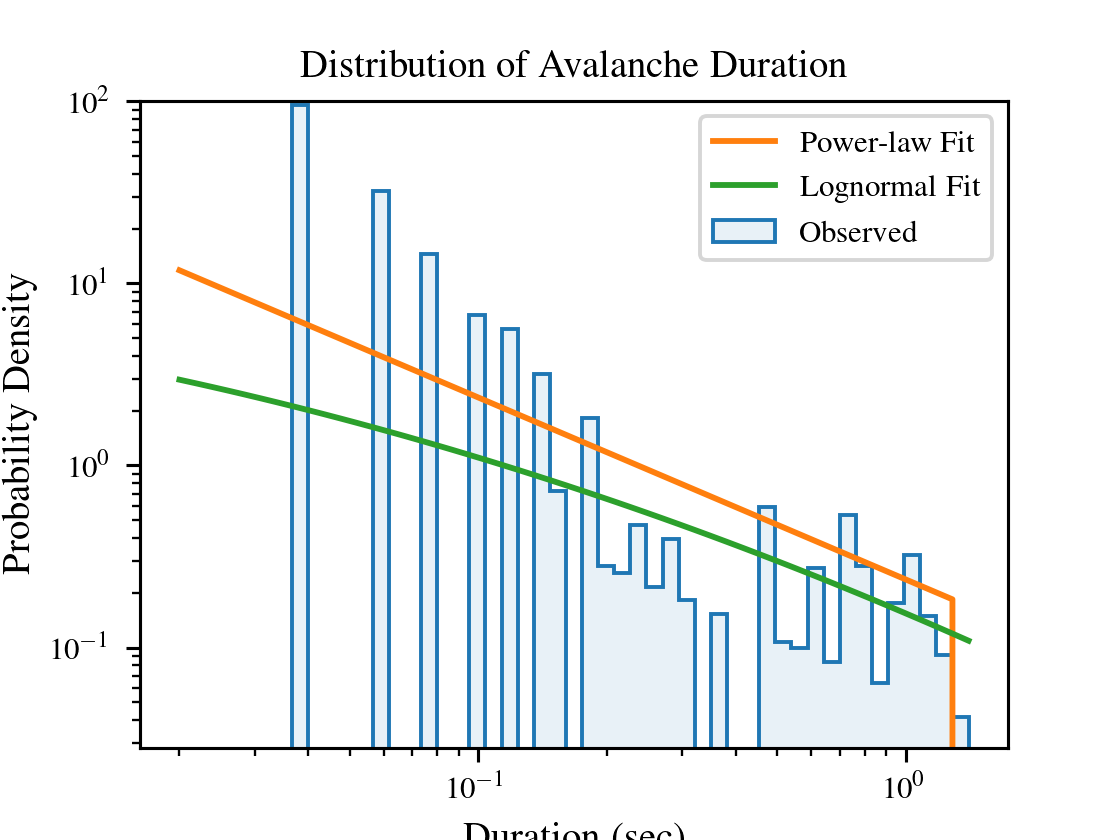

In [136]:
ax = plt.figure().gca()
ax.set_title('Distribution of Avalanche Duration')
ax.set_ylabel('Probability Density')
ax.set_xlabel('Duration (sec)')

drange = np.geomspace(durations.min(), durations.max())
empirical_pdf(ax, durations, bins=drange, label='Observed')
ylim = ax.get_ylim()[1]

ax.loglog(drange, duration_pl.pdf(drange), label='Power-law Fit')
ax.plot(drange, duration_ln.pdf(drange), label='Lognormal Fit')

ax.set_ylim(ax.get_ylim()[0], ylim)
ax.legend()

## DCC Calculation
If the data _did_ actually seem to follow a power law, this code would calculate the DCC and determine that we are actually at criticality. However, since the data aren't even scale-free in the first place, any calculated DCC value is garbage.

Also note that the relationship between duration and spike count is linear ($m=1$), which means that the average number of spikes per time has no relationship to avalanches. This is another proof that the model is nowhere near critical. I expect this to be closely related to the branching factor. In vertebrates, it seems very conserved at about $m=1.2$, but apparently in zebrafish it was measured at about $m=2$.

In [137]:
from scipy import optimize
def powerlaw(x, a,b):
    return a*x**b

(scale,m),_ = optimize.curve_fit(powerlaw, durations, sizes)
print(f'Fitted value of m: {m}')

Fitted value of m: 1.120357831580536


In [138]:
alpha, tau_dcc = 1/duration_pl.args[0], 1/size_pl.args[0]
m_pred = (tau_dcc - 1) / (alpha - 1)
print(f'Predicted value of m: {m_pred}')

Predicted value of m: 2.4742647058823533


In [139]:
print(f'DCC = {abs(m_pred - m)}')

DCC = 1.3539068743018172


<IPython.core.display.Javascript object>


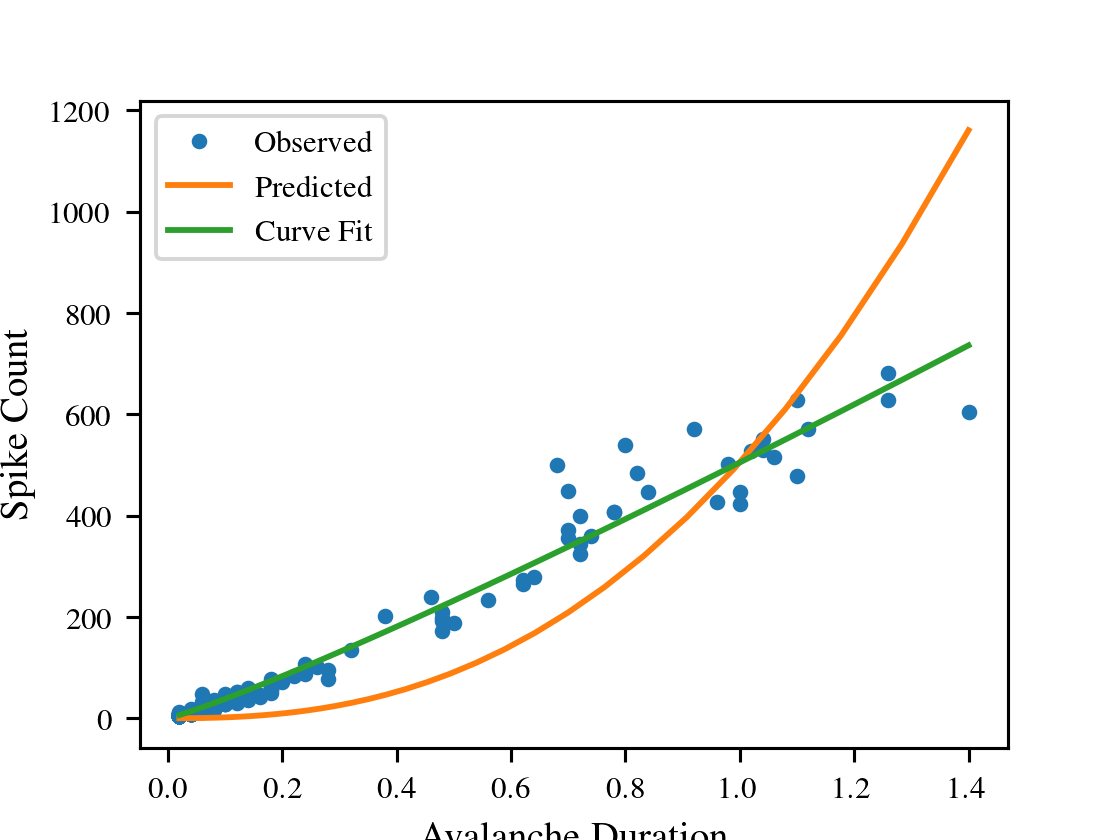

In [140]:
ax = plt.figure().gca()
ax.plot(durations, sizes, '.', label='Observed')
ax.plot(drange, scale*drange**m_pred, label='Predicted')
ax.plot(drange, scale*drange**m, label='Curve Fit')
ax.set_xlabel('Avalanche Duration')
ax.set_ylabel('Spike Count')
ax.legend()